## This notebook shows how to use supervised learning to find better term weights for `occams`


One of the most important ingredients to `occams` is the notion of term weights.  This is the amount of importance we put on including a certain word in our computed summary.  The more weight we put on a term, the more likely it is to be selected.  There are robust defaults in `occams` that generally work well, but it is also possible to get better performance with some domain knowledge and experimntation.

In this notebook, we will use supervised learning; Linear Discriminant Analysis in particualar to refine our term weights.



#### Get and filter data

These are essentially copied from our intro to `occams` bootscads notebook.
**No need to read this code.  Just run the cells and move on.**



In [1]:
from datasets import load_dataset

DATASET = ("cnn_dailymail", "3.0.0")
SPLITS = [
    "train[0%:95%]",
    "train[95%:100%]",
]  # take last 5% of train as validation data
train, test = load_dataset(*DATASET, split=SPLITS)
print(f"Loaded {DATASET[0]}.   len(train)={len(train)}    len(test)={len(test)}")

/home/vaburban/efs/home/vaburban/occams_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset cnn_dailymail (/home/vaburban/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)
100%|██████████| 2/2 [00:00<00:00,  7.94it/s]

Loaded cnn_dailymail.   len(train)=272757    len(test)=14356


In [2]:
import numpy as np
from occams.summarize import SummaryUnits

# We decide to measure our documents in characers (as opposed to words)
UNITS = SummaryUnits.CHARS


def filter_data(
    data,
    min_sum_len,
    max_sum_len,
    min_doc_len,
    doc_key="article",
    sum_key="highlights",
    UNITS=UNITS,
):
    # cnn data has 'articles' and 'highlights' instead of 'document' and 'summary'
    data = data.filter(
        lambda ex: (min_sum_len <= UNITS.len(ex[sum_key]) <= max_sum_len)
        and (UNITS.len(ex[doc_key]) > min_doc_len)
    )
    return data


def get_target_length(summaries, UNITS=UNITS, length_quantile=0.5):
    num_units = [UNITS.len(summary) for summary in summaries]
    target_length = int(np.quantile(num_units, length_quantile))
    return num_units, target_length


def truncate_data(data, max_length):
    if len(data) > max_length:
        data = data.select(range(max_length))
    return data

In [3]:
# Filter the training data
train = filter_data(train, min_sum_len=100, max_sum_len=2500, min_doc_len=100)

# Use filtered training data to get the target length for our computed summaries
num_units, target_length = get_target_length(train["highlights"])

# Filter the testing data
test = filter_data(
    test,
    min_sum_len=int(0.9 * target_length),
    max_sum_len=int(target_length),
    min_doc_len=100,
)

# truncate data (to speed up computations)
train = truncate_data(train, max_length=2000)
test = truncate_data(test, max_length=1000)

print(f"The target length is {target_length} in {UNITS.name.lower()}.")
print(f"Now, we have {len(train)} documents and summaries in our training data")
print(f"Now, we have {len(test)} documents and summaries in our testing data")

Loading cached processed dataset at /home/vaburban/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de/cache-0e575c24af0409e8.arrow
Loading cached processed dataset at /home/vaburban/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de/cache-40951ba7536e0989.arrow


The target length is 279 in chars.
Now, we have 2000 documents and summaries in our training data
Now, we have 1000 documents and summaries in our testing data


## Under the Hood of `occams`

Here, we will look more deeply into the mechanics of how `occams` works.



In [4]:
from occams.summarize import IncidenceStructure

from occams.nlp import TermOrder
from occams.nlp import process_document
from occams.summarize import SummaryUnits, TermFrequencyScheme, extract_summary
import nltk

nltk.download("punkt")  # needed to segment documents into sentences

# Set the term order to UNIGRAMS
TERMORDER = TermOrder.UNIGRAMS

# parse documents and summaries
documents_train = [
    [process_document(text, term_order=TERMORDER)] for text in train["article"]
]
summaries_train = [
    [process_document(text, term_order=TERMORDER)] for text in train["highlights"]
]
documents_test = [
    [process_document(text, term_order=TERMORDER)] for text in test["article"]
]

[nltk_data] Downloading package punkt to /home/vaburban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# We compute background counts which are needed for one of the features.

In the code above, we turned text into `Document` objects.  These `Docuemnts` can be used to create the notion of an `IncidenceStructure`.  This simply encodes which terms are present in which sentences.  The name comes from viewing the terms and sentences as nodes in a bi-partite graph.  The terms being one of the two independent sets (of vertices) in the graph and the sentences being the other.  There is an edge between term_i and sentence_j if and only if term_i occurs in sentece_j.

This book-keeping gadget will be very useful to help us compute term weights.

In [5]:
from itertools import chain

backgound_incidence = IncidenceStructure(list(chain(*documents_train)))
background_term_counts = backgound_incidence.term_counts()

print(
    f"The ten most frequent terms (and their counts) in the training documents were:{background_term_counts.most_common(10)}"
)

The ten most frequent terms (and their counts) in the training documents were:[(('the',), 72344), (('to',), 32856), (('of',), 29839), (('a',), 29460), (('and',), 29003), (('in',), 26489), (('said',), 13319), (('that',), 13291), (('for',), 10841), (('it',), 10654)]


### The following class employs a feature based classifier to learn term weights. We have three features, the relative location of the term in the text, importance based on expected occurrence, and finally the log probability.

In [6]:
from multiprocessing import Pool
from occams.termweights import fisher_term_weights
from occams.summarize import IncidenceStructure
from occams.nlp import Document, T
from typing import Callable, Dict, List, Union
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as Classifier
import pandas as pd
import seaborn as sb


class term_weight_learner:
    def __init__(
        self,
        background_term_counts: Dict,
        classifier: Callable = Classifier(),
        features: List = ["First Occur", "Fisher", "Log Prob"],
        NPROCS: int = 4,
    ):
        self._background_term_counts = background_term_counts
        self._classifier = classifier
        self._features = features
        self._num_class = np.array([0.0, 0.0])
        self._priors = np.array([0.0, 0.0])
        self._NPROCS = NPROCS

    def fit(
        self,
        documents: Union[List[List[Document[T]]], List[Document[T]]],
        summaries: Union[List[List[Document[T]]], List[Document[T]]],
    ):
        # Here we assume each item in the list of documents is a document set
        with Pool(self._NPROCS) as mypool:
            xx = mypool.starmap(
                self.get_feats_and_class_labels, zip(documents, summaries)
            )
            X, y, _ = zip(*list(xx))
        X = np.concatenate(X, axis=0)
        y = np.concatenate(y)
        len_y = len(y)
        self._num_class[1] = y.sum()
        self._num_class[0] = len_y - self._num_class[1]
        self._priors[0] = (len_y - self._num_class[1]) / len_y
        self._priors[1] = self._num_class[1] / len_y
        t = np.hstack((X, y.reshape(-1, 1)))
        columns = [*self._features, "summary terms"]
        df = pd.DataFrame(t, columns=columns)
        sb.pairplot(df, hue=columns[-1], markers=".", kind="scatter", diag_kind="kde")
        self._classifier.fit(X, y)

    def predict(self, documents: List[Document[T]]):
        X, y, terms = self.get_feats_and_class_labels(documents, None)
        y_hat = self._classifier.predict(X)
        term_weights = dict(zip(terms, y_hat))
        return term_weights

    def predict_log_proba(self, documents: List[Document[T]]):
        X, y, terms = self.get_feats_and_class_labels(documents, None)
        # Not all classifers have predict_log_proba, so we need to
        # compute it in this case
        y_proba = self._classifier.predict_proba(X)
        # Smooth the probability to avoid
        y_log_proba = np.log(y_proba + 1.0 / len(y_proba))
        # We use the empirical priors to offset the scores. Note terms with non-positive term weighting are
        # later set to 0 by occams term weight rescaling
        offset = np.log(self._priors[0] / self._priors[1])
        term_weights = y_log_proba[:, 1] + offset
        return term_weights

    def get_feats_and_class_labels(self, documents, summaries=None):
        incidence = IncidenceStructure(documents)
        terms = incidence.terms()
        term_counts = np.array(list(incidence.term_counts().values()))
        term_log_probs = list(np.log(term_counts / term_counts.sum()))
        fisher_weights = fisher_term_weights(
            incidence.term_counts(), self._background_term_counts
        )
        fisher_weights = list(fisher_weights.values())
        A = incidence.term_sent_matrix()
        nterms, nsents = A.shape
        first_occur = np.log((1 + np.argmax(A, axis=1)) / nsents)
        first_occur = np.array(first_occur).flatten()
        X = [
            [fo, tw, lp]
            for fo, tw, lp in zip(first_occur, fisher_weights, term_log_probs)
        ]
        if summaries is not None:
            summary_terms = [
                term
                for summary in summaries
                for sentence in summary.sentences
                for term in sentence.terms
            ]
            set_of_summary_terms = set(summary_terms)
            y = [int(term in set_of_summary_terms) for term in incidence.terms()]
            y = np.array(y)
        else:
            y = []
        return (X, y, terms)

## Fit the term_weight_learn using background_counts and training doc, summary pairs

CPU times: user 57.4 s, sys: 2.35 s, total: 59.7 s
Wall time: 2min 13s


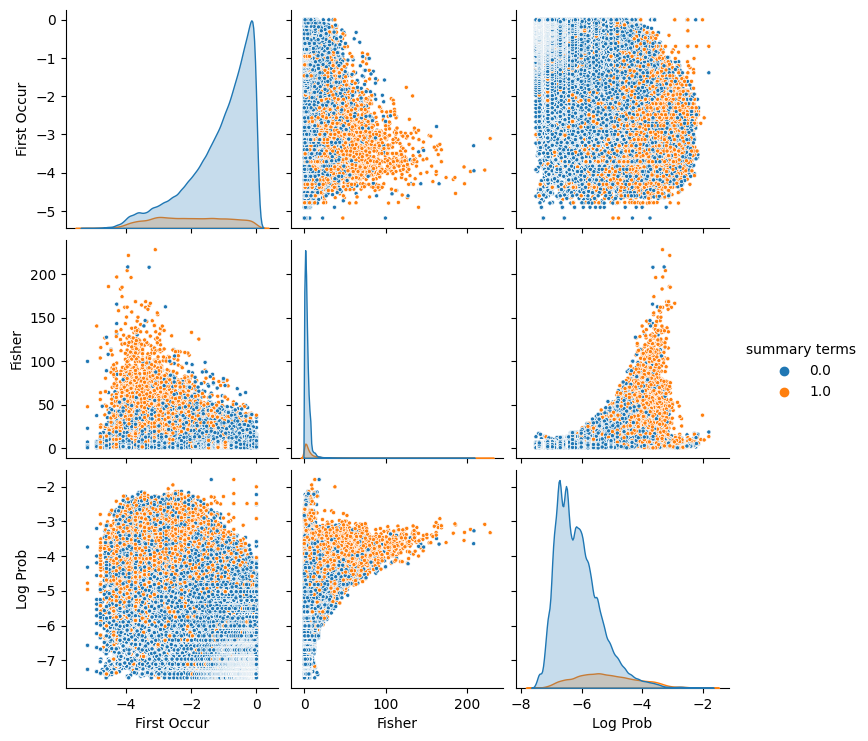

In [7]:
%%time


tw_learner = term_weight_learner(
    background_term_counts, classifier=Classifier(), NPROCS=2
)
tw_learner.fit(documents_train, summaries_train)

In [8]:
# Print the priors from the training data, the second number giving the probability a
# term from a document is in a human summary.
print("priors ")
print(tw_learner._priors)
print("means")
print(tw_learner._classifier.means_);

priors 
[0.88951719 0.11048281]
means
[[-1.11361676  3.43410913 -6.12676736]
 [-2.01645434  8.10593238 -5.19125032]]


In [9]:
# Now let's compute the occam summaries based on the trained term weights
# This function takes a list of documents and uses the method predict_term_weights from
# the TermWeightLearner  obsject tw_learner.
from occams.summarize import SummaryExtractor, IncidenceStructure


def get_extract_summary(docs, units):
    term_weights = tw_learner.predict_log_proba(docs)
    m = IncidenceStructure(docs)
    s = SummaryExtractor(m, term_weights=term_weights, units=units)
    # do actual summarization
    extract = s.extract_best(budget=target_length)
    return extract


extracts_learned_tw = [
    get_extract_summary(doc, units=UNITS).summary() for doc in documents_test
]

#### Back to (automatic) evaluation.  ROUGE scores

First we get the compute_rouge_scores function again (as we did in the original bootscads notebook).
Then, we run it on our summaries we computed with termweights learned from supervised learing.

In [10]:
from occams.rouge_eval import rouge_n_r


def compute_rouge_scores(extracts, summaries, target_length, units=SummaryUnits.WORDS):
    rouges = []
    for this_summary, model in zip(extracts, summaries):
        rouge = rouge_n_r(
            this_summary, model, summary_length=target_length, units=units, max_n=4
        )
        rouges.append(rouge[1:])
    rouges = np.array(rouges)
    return rouges


# FOR COMPARISON PURPOSES, get the original rouge scores we computed in the first notebook
extracts_orig = [
    extract_summary(documents=doc, budget=target_length, units=UNITS)
    for doc in documents_test
]
orig_occams_summaries = [extract.summary() for extract in extracts_orig]
rouges = compute_rouge_scores(
    orig_occams_summaries, test["highlights"], target_length, units=UNITS
)


# We compute the rouge scores of the summaries from the new term weights done with classification (supervised learning)
rouges_cl = compute_rouge_scores(
    extracts_learned_tw, test["highlights"], target_length, units=UNITS
)

In [11]:


print(
    "Mean ROUGE scores using unsupervised as well as %d training data on %s."
    % (len(documents_train), DATASET[0])
)
# print('The training data was filtered so the min and maximumum summary lengths were in (%d,%d)'%(MIN_SUMMARY_LENGTH,MAX_SUMMARY_LENGTH))
print("We used %s as our term order" % str(TERMORDER))
print("The target length summary length was %d %s" % (target_length, str(UNITS)))
print(
    "Using supervised learning with %s the ROUGE scores were" % tw_learner._classifier
)

print(np.mean(rouges_cl, axis=0))
print("Where as the unsupervised approach ROUGE scores were")
print(np.mean(rouges, axis=0))

Mean ROUGE scores using unsupervised as well as 2000 training data on cnn_dailymail.
We used TermOrder.UNIGRAMS as our term order
The target length summary length was 279 SummaryUnits.CHARS
Using supervised learning with LinearDiscriminantAnalysis() the ROUGE scores were
[0.39602452 0.16029931 0.09065902 0.0599796 ]
Where as the unsupervised approach ROUGE scores were
[0.363721   0.12034368 0.06302676 0.03943242]


#### This compares using bigrams and using different term frequency schemes

In [12]:
documents_test_bigrams = [
    [process_document(text, term_order=TermOrder.BIGRAMS)] for text in test["article"]
]

# documents_test_bigrams = process_documents(test[DOCUMENT],term_order=TermOrder.BIGRAMS,NPROCS=NPROCS)
for scheme in [
    TermFrequencyScheme.POSITIONAL_DENSE,
    TermFrequencyScheme.CORE_SENTENCES,
    TermFrequencyScheme.CORE_TERMS,
]:
    extracts_bigrams = [
        extract_summary(
            documents=doc, budget=target_length, units=UNITS, scheme=scheme
        ).summary()
        for doc in documents_test_bigrams
    ]
    rouges_bigrams = compute_rouge_scores(
        extracts_bigrams, test["highlights"], target_length, units=UNITS
    )
    print(
        "ROUGE scores when using unsupervised BIGRAMS model with scheme=%s"
        % str(scheme)
    )
    print(np.mean(rouges_bigrams, axis=0))

ROUGE scores when using unsupervised BIGRAMS model with scheme=TermFrequencyScheme.POSITIONAL_DENSE
[0.36218015 0.13483707 0.07350459 0.04755915]
ROUGE scores when using unsupervised BIGRAMS model with scheme=TermFrequencyScheme.CORE_SENTENCES
[0.35605435 0.14059334 0.08118653 0.0542986 ]
ROUGE scores when using unsupervised BIGRAMS model with scheme=TermFrequencyScheme.CORE_TERMS
[0.32790887 0.11714517 0.06778576 0.04629214]


In [13]:
# Now let's test for statistical significance using a pairwise Wilcoxon test
from scipy.stats import wilcoxon, describe

pvalues = []
for i in range(4):
    res_wilcoxon = wilcoxon(rouges_cl[:, i], rouges[:, i])
    pvalues.append(res_wilcoxon.pvalue)
print("p-values between supervised and unsupervised occams:")
print(pvalues)
print(
    "A description (summary statistics ) of the lengths of the testing data summaries."
)
tl = [UNITS.len(text) for text in test["highlights"]]
print(describe(tl))

p-values between supervised and unsupervised occams:
[1.0713906760789338e-18, 2.5716808199730033e-31, 7.659389913587853e-22, 1.4461040327442825e-16]
A description (summary statistics ) of the lengths of the testing data summaries.
DescribeResult(nobs=1000, minmax=(251, 279), mean=268.036, variance=70.12883283283284, skewness=-0.4787941886576967, kurtosis=-0.9628620545335633)


-------------- 
-------------- 
-------------- 



# Apendix:
-------------- 
## Archived results for comparison purposes only
-------------- 

##### cnn_dailymail dataset results
```
Mean ROUGE scores using 10000 training data on cnn_dailymail.
The training data was filtered so the min and maximumum summary lengths were in (100,2500)
We used TermOrder.UNIGRAMS as our term order
The target length summary length was 279 SummaryUnits.CHARS
Using supervised learning with LinearDiscriminantAnalysis() the ROUGE scores were
[0.39609195 0.1606945  0.09127822 0.06042444]
Where as the unsupervised approach ROUGE scores were
[0.36342407 0.12010013 0.06279958 0.03926778]
summa textrank
[0.32004086 0.11453463 0.06136315 0.03954933]
ROUGE scores when using unsupervised BIGRAMS model with scheme=TermFrequencyScheme.POSITIONAL_DENSE
[0.36234272 0.13504155 0.07363269 0.04764867]
ROUGE scores when using unsupervised BIGRAMS model with scheme=TermFrequencyScheme.CORE_SENTENCES
[0.35624726 0.14057249 0.08116258 0.05429663]
ROUGE scores when using unsupervised BIGRAMS model with scheme=TermFrequencyScheme.CORE_TERMS
[0.3280842  0.11682969 0.06725519 0.04572251]

```